In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import datetime
%matplotlib inline

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.metrics import r2_score

import warnings


In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
warnings.filterwarnings("ignore")

# 1 - Visualize the time series

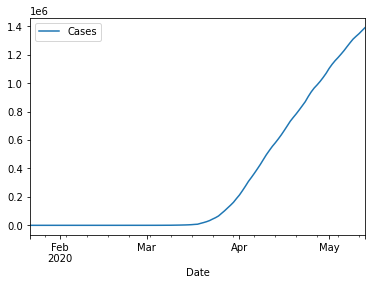

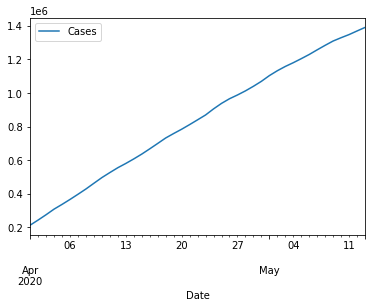

In [3]:
r = requests.get("https://covid-mgzrmsj5kq-uc.a.run.app/API/usa/timeseries/")
response_dict = r.json()
dataset = pd.DataFrame.from_dict(response_dict)
dataset = dataset.rename(columns={'Total Results as of Date': 'Date'})
dataset["Date"] = pd.to_datetime(dataset["Date"])

dataset = dataset.set_index("Date")
dataset.drop(columns=["ISO3", "Country", "Deaths", "Recovered"], inplace=True)
dataset.dropna(inplace=True)

#filter the whole data by mean of newCases
df = dataset[dataset.Cases >= 200000]

dataset.plot()
df.plot()

In [4]:
df.describe()

,Cases
count,43.000
mean,832892.674
std,357488.104
min,213242.000
25%,540854.500
50%,840351.000
75%,1145289.500
max,1390406.000


## For this analysis we are gonna use the data only with more than 200000 cases.

<Figure size 432x288 with 0 Axes>

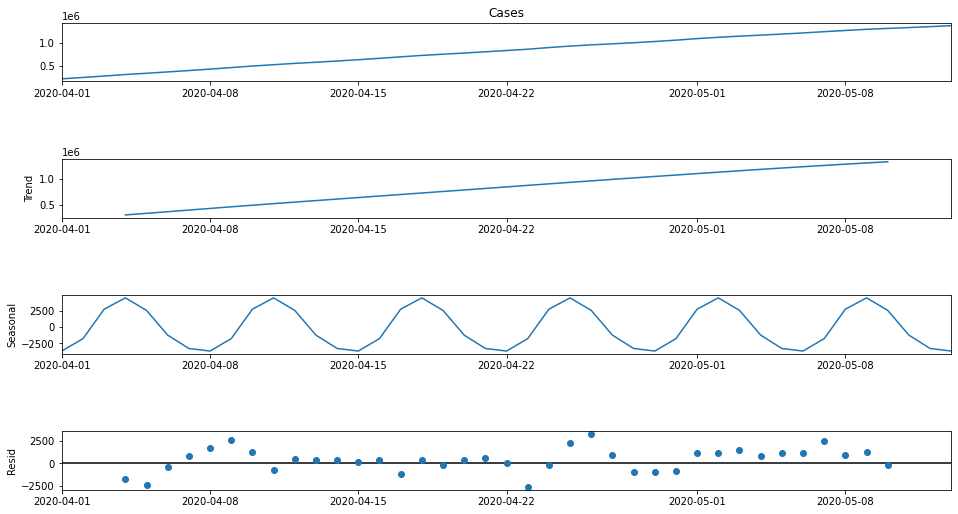

In [5]:
decomposition = seasonal_decompose(df.Cases, period=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [6]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid
# print(trend)
# print(seasonal)
# print(residual)

In [7]:
#Ho: It is non stationary
#H1: It is stationary
#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
# p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.


def adfuller_test(data):
    result=adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used','Critical Values:']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
def plot_adfuller_test(data):
    
    #Determing rolling statistics
    rolmean = data.rolling(window=8).mean()
    rolstd = data.rolling(window=8).std()

    #Plot rolling statistics:
    orig = plt.plot(data, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)


In [8]:
adfuller_test(df.Cases)

ADF Test Statistic : -0.9610075507607259
p-value : 0.7672190165252202
#Lags Used : 7
Number of Observations Used : 35
Critical Values: : {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [9]:
#plot_adfuller_test(df.Cases)

#### Determine whether your original time series needs any nonlinear transformation(s) such as logging and/or deflating and/or raising-to-some-power in order to be converted to a form where its local random variations are consistent over time and generally symmetric in appearance. 

Let Y denote the time series you end up with after step 1. If Y is still “nonstationary” at this point, i.e., if it has a linear trend or a nonlinear or randomly-varying trend or exhibits random-walk behavior, then apply a first-difference transformation, i.e., construct a new variable that consists of the period-to-period changes in Y.

If it STILL looks non-stationary after a first-difference transformation, which may be the case if Y was a relatively smoothly-varying series to begin with, then apply another first-difference transformation i.e., take the first-difference-of-the-first difference.


# 2 - Stationarize the time series

#### A stationary (time) series is one whose statistical properties such as the mean, variance and autocorrelation are all constant over time. Hence, a non-stationary series is one whose statistical properties change over time.

There are various transformations that we can do to stationarize the data.

* Deflation by CPI
* Logarithmic
* First Difference
* Seasonal Difference
* Seasonal Adjustment

We used First Difference and Seasonal Difference for this analysis.

In [10]:
df['FirstDiff'] = df['Cases'] - df['Cases'].shift(1)
adfuller_test(df.FirstDiff.dropna(inplace=False))

ADF Test Statistic : 1.5260933926041027
p-value : 0.9976180042867906
#Lags Used : 6
Number of Observations Used : 35
Critical Values: : {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [11]:
df['SecondDiff'] = df['FirstDiff'] - df['FirstDiff'].shift(1)
adfuller_test(df.SecondDiff.dropna(inplace=False))




ADF Test Statistic : -5.316340874658438
p-value : 5.0646352175298715e-06
#Lags Used : 5
Number of Observations Used : 35
Critical Values: : {'1%': -3.6327426647230316, '5%': -2.9485102040816327, '10%': -2.6130173469387756}
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


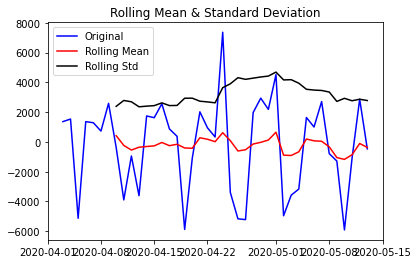

In [12]:
plot_adfuller_test(df.SecondDiff.dropna(inplace=False))

## As you can see by the p-value, taking the first difference has now made our data stationary. 

# 3 - Plot ACF/PACF charts and find optimal parameters

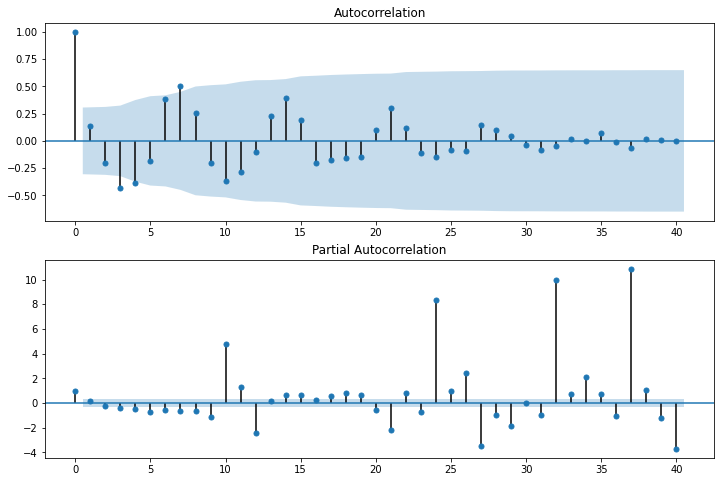

In [13]:

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.SecondDiff.iloc[2:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.SecondDiff.iloc[2:],lags=40,ax=ax2)

# 4 - Build the ARIMA model

In [14]:
from statsmodels.tsa.arima_model import ARIMA
# For non-seasonal data

model=ARIMA(((df['SecondDiff']).dropna()),order=(2,0,2))
model_fit=model.fit()
#print(model_fit.summary())

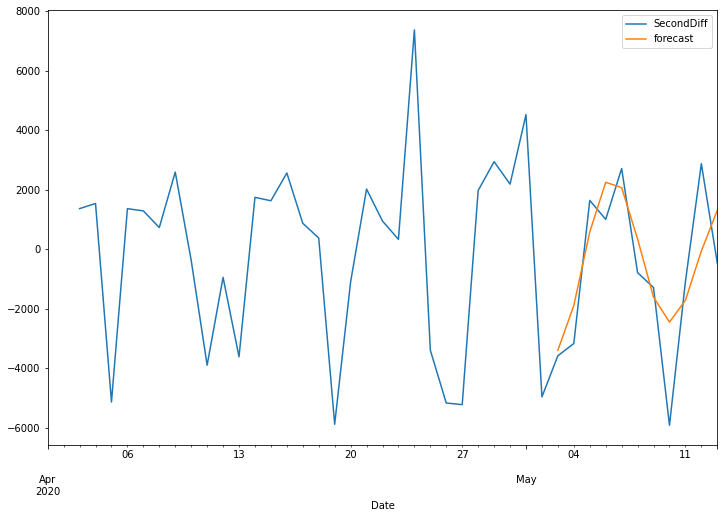

In [15]:
df['forecast']=model_fit.predict(start=30,end=120,dynamic=True)
df[['SecondDiff','forecast']].plot(figsize=(12,8))

# 5 - Make predictions

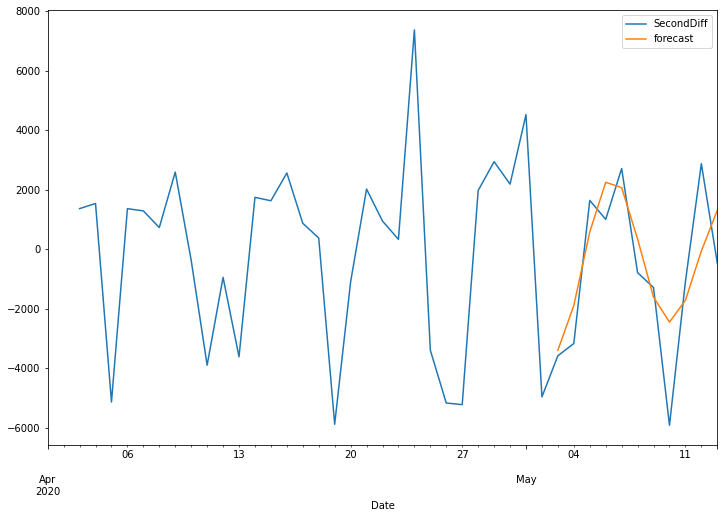

In [16]:
df['forecast'] = model_fit.predict(start = 30, end= 115, dynamic= True)  
df[['SecondDiff', 'forecast']].plot(figsize=(12, 8))

#### 

In [17]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(days=x)for x in range(0,14)]

In [18]:
df.tail()

,Cases,FirstDiff,SecondDiff,forecast
Date,,,,
2020-05-09,1309550,25621.000,-1285.000,-1608.603
2020-05-10,1329260,19710.000,-5911.000,-2447.787
2020-05-11,1347881,18621.000,-1089.000,-1714.161
2020-05-12,1369376,21495.000,2874.000,-57.952
2020-05-13,1390406,21030.000,-465.000,1310.753


In [19]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)
future_datest_df.tail()

,Cases,FirstDiff,SecondDiff,forecast
2020-05-22,NaN,NaN,NaN,NaN
2020-05-23,NaN,NaN,NaN,NaN
2020-05-24,NaN,NaN,NaN,NaN
2020-05-25,NaN,NaN,NaN,NaN
2020-05-26,NaN,NaN,NaN,NaN


In [20]:
future_df=pd.concat([df,future_datest_df])

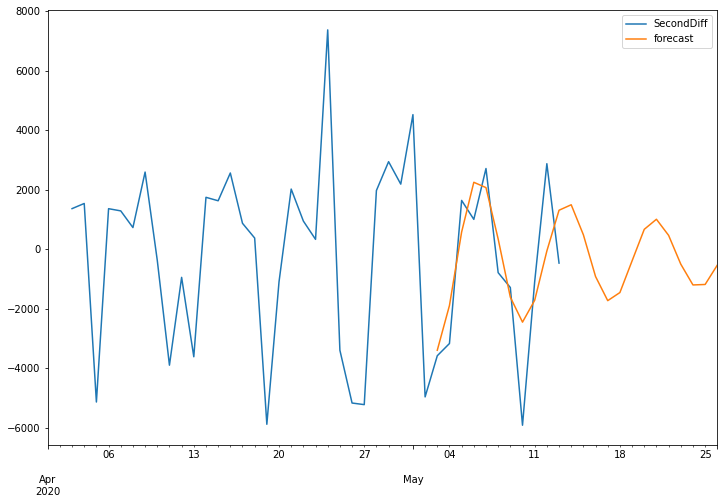

In [21]:
future_df['forecast'] = model_fit.predict(start = 30, end = 120, dynamic= True) 
future_df[['SecondDiff', 'forecast']].plot(figsize=(12, 8))

In [22]:
future_df.tail(20)

,Cases,FirstDiff,SecondDiff,forecast
2020-05-07,1257023,27692.000,2712.000,2071.168
2020-05-08,1283929,26906.000,-786.000,345.501
2020-05-09,1309550,25621.000,-1285.000,-1608.603
2020-05-10,1329260,19710.000,-5911.000,-2447.787
2020-05-11,1347881,18621.000,-1089.000,-1714.161
2020-05-12,1369376,21495.000,2874.000,-57.952
2020-05-13,1390406,21030.000,-465.000,1310.753
2020-05-14,NaN,nan,nan,1494.939
2020-05-15,NaN,nan,nan,486.311
2020-05-16,NaN,nan,nan,-916.288


In [23]:
future_df[future_df['forecast'].notnull() & (future_df['SecondDiff'].isnull())]


,Cases,FirstDiff,SecondDiff,forecast
2020-05-14,NaN,nan,nan,1494.939
2020-05-15,NaN,nan,nan,486.311
2020-05-16,NaN,nan,nan,-916.288
2020-05-17,NaN,nan,nan,-1726.069
2020-05-18,NaN,nan,nan,-1453.795
2020-05-19,NaN,nan,nan,-389.679
2020-05-20,NaN,nan,nan,669.266
2020-05-21,NaN,nan,nan,1007.717
2020-05-22,NaN,nan,nan,467.573
2020-05-23,NaN,nan,nan,-499.837


In [24]:
print((future_df['forecast'][55:]))


2020-05-26   -533.160
Name: forecast, dtype: float64


In [25]:
compare_df= df[['SecondDiff', 'forecast']].dropna()


In [26]:
r2_score(compare_df.SecondDiff, compare_df.forecast)


0.5955695115535424